In [9]:
# -*- coding: utf-8 -*-
"""FHO - Fire Hawk Optimizer Algorithm

Algorithm based on the publication : https://link.springer.com/article/10.1007/s10462-022-10173-w
Original Authors: Mahdi Azizi, Siamak Talatahari & Amir H. Gandomi
Original Python file developped by : Adel Remadi and Hamza Lamsaoub  (Students at CentraleSupélec)
"""

import numpy as np
import matplotlib.pyplot as plt
#from models.multiple_solution.root_multiple import RootAlgo


#class FHO(RootAlgo):
class FHO():
    """ Class for FHO 
    ---------
    self.cost_function: function to optimize
    self.Pop : np.array of Generated Solution Candidates of shape (pop_size,n_dims)
    self.n_dims: dimension of the problem
    self.pop_size : Number of solution candidates (int)
    self.min_bounds : numpy array of dimension (n_dims,) containing the MIN value for each variable
    self.max_bounds : numpy array of dimension (n_dims,) containing the MAX value for each variable
    self.max_generations: Maximum number of generated candidates (int)
    self.best_costs: python list of best costs (list)
    self.costs_iter : python list of cost calculated in each MAIN iteration (list)
    self.minimal_p : minimal point as a numpy array of dimensions (n_dims,)
    self.path :  A list containing the trajectory of the best hawks
    """
    
    def __init__(self, min_bounds , max_bounds, pop_size, cost_function , max_generations=200):
        self.max_generations = max_generations
        self.min_bounds      = min_bounds
        self.max_bounds      = max_bounds
        self.cost_function   = cost_function
        self.pop_size        = pop_size
        self.n_dims          = len(min_bounds) #Number of decision variables
        self.Pop             = np.random.uniform(min_bounds,max_bounds,(pop_size,self.n_dims)) #Initial Solution candidates (pop_size,n_dims)
        self.best_costs      = []
        self.costs_iter      = []
        self.minimal_p       = None
        self.path            = []
        
    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i           
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)
            
            #Get territory of fire Hawk i 
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]          
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories
            
                      
    def minimize_FHO(self):
        '''
        Input:
        self
        
        Output:
        GB : global best solution (min f(x))
        self.minimal_p minimal point as a numpy array of dimensions (n_dims,)
        '''
        ## Fire hawk algorithm to minimize the cost function       
        n_dims=self.n_dims
        Pop=self.Pop
        pop_size=self.pop_size
        max_generations = self.max_generations  
        min_bounds=self.min_bounds
        max_bounds=self.max_bounds
        cost_function = self.cost_function
        
        #Evaluate the cost function for all candidate vectors
        cost= np.array([cost_function(Pop[i]) for i in range(pop_size)])
        
        #Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
        
        #Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP=Pop.mean(axis=0)
         
        
        #Select fire hawks
        Fire_Hawks= Pop[:num_Hawks]
        
        #Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]
        
        #get territories
        territories=self.territories(Fire_Hawks,Preys)
        
        #update best
        GB=cost[0]
        Best_Hawk=Pop[0]
        self.path.append(Best_Hawk)

        #Counter
        FEs=pop_size

        ## Main Loop
        while FEs < max_generations:
            Pop_Tot=[]
            cost=[]
            #Movement of Fire Hawk for all territories
            for i in territories:
                PR=territories[i].copy()
                FHl=Fire_Hawks[i].copy()
                SPl=PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a,b=np.random.uniform(0,1,size=2)
                FHnear  =Fire_Hawks[np.random.randint(num_Hawks)]                 
                FHl_new =FHl+(a*GB-b*FHnear)
                FHl_new = np.maximum(FHl_new,min_bounds)
                FHl_new = np.minimum(FHl_new,max_bounds)
                Pop_Tot.append(list(FHl_new))
                
                #Movement of the preys following Fire Hawks movement
                for q in range(len(PR)): 
                    a,b=np.random.uniform(0,1,size=2)
                    PRq_new1=PR[q].copy()+((a*FHl-b*SPl))
                    PRq_new1= np.maximum(PRq_new1,min_bounds)
                    PRq_new1 = np.minimum(PRq_new1,max_bounds)
                    Pop_Tot.append(list(PRq_new1))
                    
                    #Movement of the preys outside of territory
                    a,b      =np.random.uniform(0,1,size=2)
                    FHAlter  =Fire_Hawks[np.random.randint(num_Hawks)] 
                    PRq_new2 =PR[q].copy()+((a*FHAlter-b*SP));
                    PRq_new2 = np.maximum(PRq_new2,min_bounds)
                    #The following line for PRq_new2 differs from original algorithm in matlab code (max instead of min):
                    # Effects observed through our testing:
                    # 1/ It converges faster and the costs of the subsequent iterations will tend to decrease (less chaotic behavior than with np.minimun)
                    # 2/ In higher dimensions, it converge to the right solution! (while with np.minimum it does not)
                    PRq_new2 = np.maximum(PRq_new2,max_bounds)
                    Pop_Tot.append(list(PRq_new2))
                             
            #Get cost
            Pop_Tot=np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs = FEs+1
     
            #Create a new population of Hawks and Preys
            order_idx=np.argsort(cost)
            cost.sort()
            Pop_Tot=np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
            Best_Pop=Pop_Tot[0]
            SP=Pop_Tot.mean(axis=0)
            Fire_Hawks=Pop_Tot[:num_Hawks]
            Preys=Pop_Tot[num_Hawks:]          
               
            #Get new territories
            territories=self.territories(Fire_Hawks,Preys)
           
            # Update Global Best cost (if relevant) 
            if cost[0]<GB:
                Best_Position=Best_Pop
                GB=cost[0]
                self.best_costs.append(GB)
                self.minimal_p=Fire_Hawks[0]
                self.path.append(Best_Position)
            else:
                self.best_costs.append(GB)
           
            #Track the iteration calculated cost
            self.costs_iter.append(cost[0])

        #Return Global Best and argmin
        return (GB,self.minimal_p)
            
    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()
        
    def plot_log_costs(self):
        #Plot cost evolution
        vals=np.log(self.costs_iter)
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
      return np.array(self.path).T

<h1>1. Sphere</h1>

Below are plots of the Sphere function in 2-Dimensions and an analysis in 25-Dimensions.

<h2>1.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

/var/folders/j6/f2v7jnsj2s93z789zkp012cc0000gn/T/ipykernel_80090/2375171615.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = figure.gca( projection='3d')


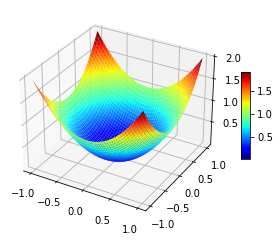

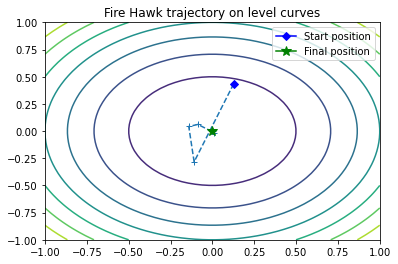

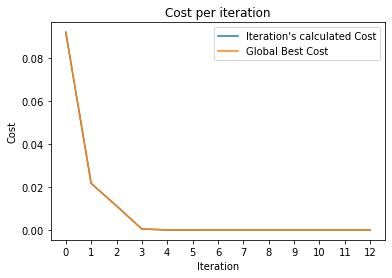

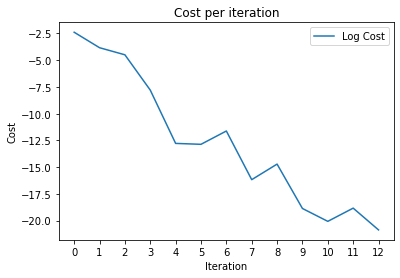


 Global best cost is  8.665145678612741e-10

 Global best position is  [2.74788601e-05 1.05558901e-05]


In [8]:
def f(x1,x2):
  a= x1**2+x2**2
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet')
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()

fonction=lambda x : np.linalg.norm(x)**2

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=2000000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()


#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()
opti.plot_log_costs()
#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)


<h2>1.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the sphere in 25-Dimensions. We ran it on a range [-100,100] for each axis.

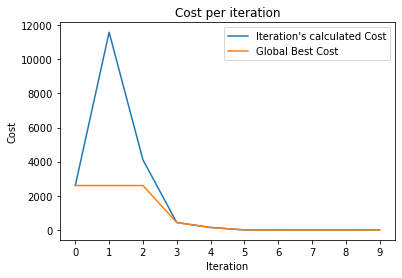

(0.0030910212912080874,
 array([-0.01069432, -0.01401258, -0.01144345, -0.00669961, -0.00840761,
        -0.00748001, -0.00990509, -0.01070829, -0.01204393, -0.01328492,
        -0.01096854, -0.01157979, -0.01030138, -0.01100686, -0.01266208,
        -0.01502372, -0.007307  , -0.00835179, -0.01312735, -0.0137916 ,
        -0.00904666, -0.01094325, -0.00783212, -0.01282949, -0.01275052]))

In [3]:
fonction=lambda x : np.linalg.norm(x)**2

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>2. Exponential</h1>

Below are plots of the Exponential function in 2-Dimensions and an analysis in 25-Dimensions.

<h2>2.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 2-Dimensions.

As seen in above plot, the minimum is f(x) = -1 and it is obtained for (x,y)=(0,0).

/var/folders/j6/f2v7jnsj2s93z789zkp012cc0000gn/T/ipykernel_72888/2460094826.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = figure.gca( projection='3d')


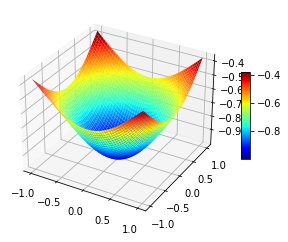

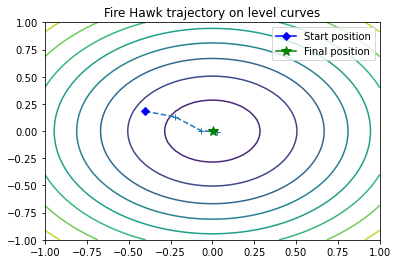

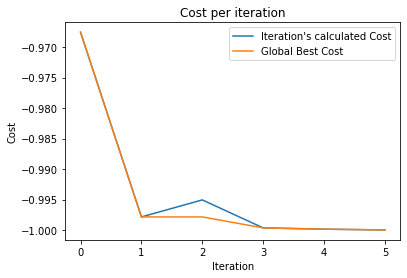


 Global best cost is  -0.9999902365216145

 Global best position is  [ 0.0040382  -0.00179444]


In [4]:
def f(x1,x2):
  a= -np.exp(-0.5*(x1*x1 + x2*x2))
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()

exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, pop_size=200, cost_function = exponential, max_generations=20000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()

#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()

#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)


<h2>2.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the exponential in 25-Dimensions. We ran it on a range [-30,30] for each axis.

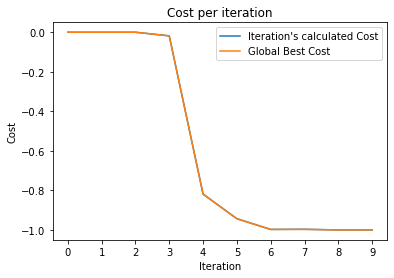

(-0.9999135025587741,
 array([-6.96175630e-05, -1.46025727e-03, -6.68802182e-03, -2.06195353e-03,
        -3.04022259e-03, -8.16018557e-04, -1.17945826e-03, -2.43526549e-03,
        -2.88709988e-03, -4.06593212e-03, -2.16463972e-03,  1.50824659e-03,
        -7.35462561e-04, -2.09311842e-03, -4.37814631e-03, -2.51088390e-03,
         1.66975885e-06, -1.76241180e-03,  3.19139864e-04, -3.12813858e-03,
        -8.92289801e-04, -1.95142204e-03, -4.23597967e-03, -1.08039695e-03,
        -2.39224031e-03]))

In [5]:
exponential = lambda x: -np.exp(-0.5*np.sum(x**2))

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, pop_size=200, cost_function = exponential, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>3. Ackley</h1>

Below are plots of the Ackley function in 2-Dimensions.

The Ackley function is non-convex, which could be a challenge for some algorithms.

<h2>3.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the ackley in 2-Dimensions.

As seen in above plot, the minimum is f(x) = 0 and it is obtained for (x,y)=(0,0).

The Ackley function has many local minimas but the algorithm do not get stuck.

/var/folders/j6/f2v7jnsj2s93z789zkp012cc0000gn/T/ipykernel_72888/1557430036.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = figure.gca( projection='3d')


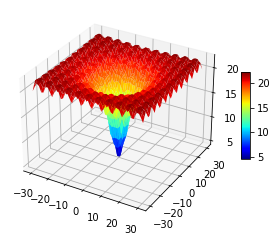

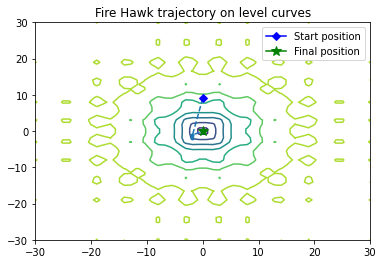

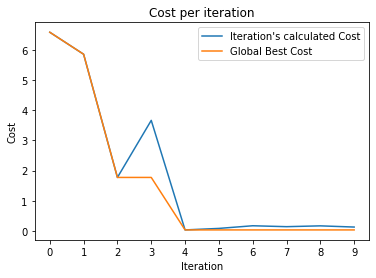


 Global best cost is  0.028327118342382107

 Global best position is  [-0.00651668 -0.00651668]


In [6]:
def f(x,y):
  return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))-np.exp(0.5 * (np.cos(2 * np.pi * x)+np.cos(2 * np.pi * y))) + np.e + 20
 

x1= np.linspace(-30,30)
x2= np.linspace(-30,30)
x, y = np.meshgrid(x1, x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()

def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=[-2,-2]
maxD=[500,200]

opti=FHO(minD , maxD, pop_size=200, cost_function =  ackley, max_generations=200000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()

#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='.')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()

#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)



<h2>3.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Ackley in 25-Dimensions. We ran it on a range [-30,30] for each axis.

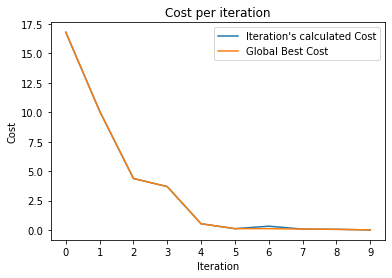

(0.017446638823898297,
 array([ 6.56011395e-03,  5.59099587e-04, -2.66500414e-03, -4.77324934e-03,
        -3.13579405e-03,  5.73849300e-03, -7.57788530e-03,  5.55060042e-03,
        -4.36760669e-03, -2.93734923e-03, -2.38112364e-03, -4.44129026e-03,
         3.34009361e-03,  6.69242525e-03, -2.69431655e-03,  2.16055948e-03,
        -4.41825406e-03,  8.42538837e-05, -6.33587667e-03, -4.91080891e-03,
         1.81801279e-03,  1.13954448e-03, -1.64577455e-03,  3.10537079e-03,
         1.15676186e-03]))

In [7]:
def ackley(x):
  sumsquares= np.sum(x**2)
  sumcos = np.sum(np.cos(2 * np.pi * x))
  return -20.0 * np.exp(-0.2 * np.sqrt(1/len(x) * sumsquares))-np.exp(1/len(x) * sumcos) + np.e + 20

minD=np.ones(25)*-30
maxD=np.ones(25)*30

opti=FHO(minD , maxD, pop_size=200, cost_function = ackley, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b


<h1>4. Becker-lago</h1>

Below are plots of the Becker-lago function in 2-Dimensions.


$$f(X)=(|x_1|−5)^2+(|x_2|−5)^2$$

A test in 25-Dimensions is also proposed in 4.b)

<h2>4.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 2-Dimensions.

As seen in above plot, the Becker-Lago is non convex, non differentiable and it has 4 minimum solutions such that $f(x) = 0$ for: 
$$$$

$$(x,y) \in \{(-5,-5),(-5,5),(5,-5),(5,5)\}$$

The below code converge towards any of the minimums.

/var/folders/j6/f2v7jnsj2s93z789zkp012cc0000gn/T/ipykernel_72888/2569410629.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = figure.gca( projection='3d')


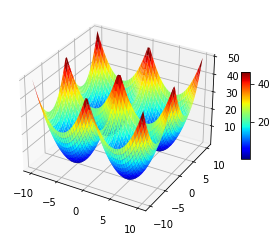

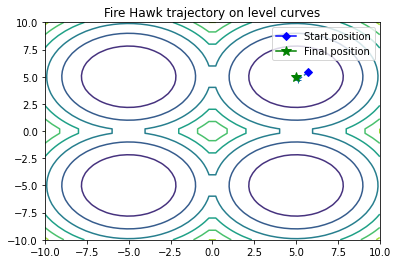

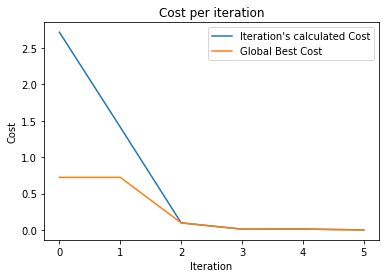


 Global best cost is  0.00048668655765179666

 Global best position is  [5.01180554 4.98136359]


In [8]:
def f(x,y):
  return (np.abs(x)-5)**2+(np.abs(y)-5)**2
 
x1= np.linspace(-10,10)
x2= np.linspace(-10,10)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()

def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=[-30,-30]
maxD=[30,30]

opti=FHO(minD , maxD, pop_size=200, cost_function = becker_lago, max_generations=20000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()

#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()

#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)


<h2>4.b) 25-Dimensions </h2>

The below code runs our FHO algorithm for the Becker-Lago in 25-Dimensions. We ran it on a range [-30,30] for each axis.

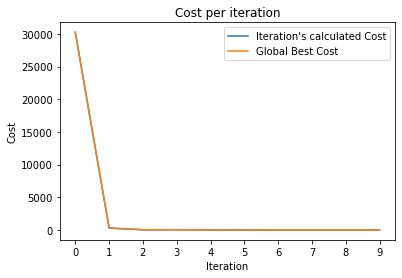

(0.0009814781914019542,
 array([5.00697284, 5.00577378, 5.00519998, 5.00277377, 5.00424585,
        5.00327087, 5.00333878, 5.00291935, 5.00429944, 5.00882919,
        5.00847434, 5.00661938, 5.00489844, 5.00183547, 5.01130943,
        5.00741418, 5.00114269, 5.00612964, 5.01073598, 5.01002888,
        4.99789409, 5.00888271, 5.00328978, 5.00281699, 5.006105  ]))

In [9]:
def becker_lago(x):
  return np.sum((np.abs(x)-5)**2)

minD=np.ones(25)*-100
maxD=np.ones(25)*100

opti=FHO(minD , maxD, pop_size=200, cost_function = becker_lago, max_generations=200000)
a,b=opti.minimize_FHO()
opti.plot_costs()
a,b

<h1>5. Bird function</h2>



<h2>5.a)  2-Dimensions </h2>

The below code runs our FHO algorithm for the Bird in 2-Dimensions.

The function has two global minima in [-2$\pi$,2$\pi$] at f(x)= −106.764537 located at :
(4.70104 ,3.15294) and  (−1.58214 ,−3.13024)

/var/folders/j6/f2v7jnsj2s93z789zkp012cc0000gn/T/ipykernel_72888/2829943693.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = figure.gca( projection='3d')


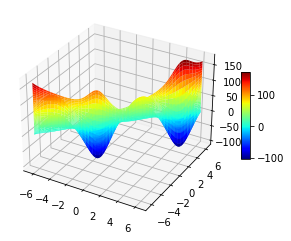

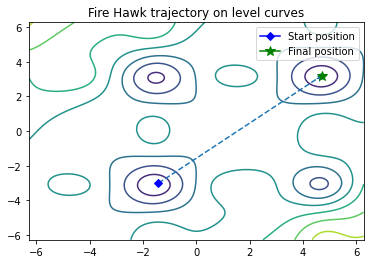

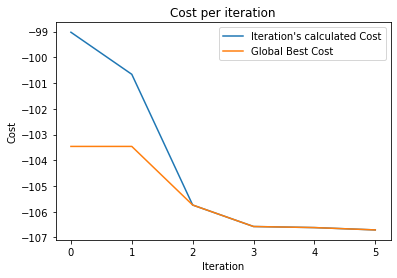


 Global best cost is  -106.70790560055846

 Global best position is  [4.72360977 3.16883743]


In [13]:
def f(x,y):
 return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

x= np.linspace(-2*np.pi,2*np.pi,1000)
y= np.linspace(-2*np.pi,2*np.pi,1000)
X,Y= np.meshgrid(x,y)
results= f(X,Y)

figure = plt.figure()
axis = figure.gca( projection='3d')
my_cmap = plt.get_cmap('jet') 
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10) 
plt.show()


def bird(X):
  x,y = X
  return np.sin(x)*(np.exp(1-np.cos(y))**2)+np.cos(y)*(np.exp(1-np.sin(x))**2)+(x-y)**2

minD=[-2*np.pi,-2*np.pi]
maxD=[2*np.pi,2*np.pi]

opti=FHO(minD , maxD, pop_size=200, cost_function =  bird, max_generations=20000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()

#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()

#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)
